<a href="https://colab.research.google.com/github/Iyeose/Thermal-comfort/blob/main/Thermal_comfort_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Data-Driven Prediction of Human Thermal Comfort Using Machine Learning Approaches

##Author : Iyeose Simon Uhumuavbi
Student Number: 2653568

---

## Step 1: Understanding the Dataset


Import all necessary libraries

---

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import RandomizedSearchCV


---
Load and inspect the ASHRAE Global Thermal Comfort Database II data set

---

In [ ]:


# Set some display options for better viewing
pd.set_option('display.max_columns', 100)
sns.set_style('whitegrid')

# Load the Data
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('ashrae_db2.01.csv')
print('\n')

# --- Initial Inspection ---
print("Shape of the dataset (rows, columns):")
print(df.shape)


print("\nFirst 5 rows of the dataset:")
print(df.head())

# Get a concise summary of the dataframe
print("\nDataFrame Info(data types and non-null values):")
df.info()

Saving ashrae_db2.01.csv to ashrae_db2.01.csv


/tmp/ipython-input-397901915.py:9: DtypeWarning: Columns (10,11,13,18,19,34,50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ashrae_db2.01.csv')




Shape of the dataset (rows, columns):
(107583, 70)

First 5 rows of the dataset:
                              Publication (Citation) Data contributor    Year  \
0  Kwok, Alison G., and Chungyoon Chun. "Thermal ...      Kwok Alison  2000.0   
1  Kwok, Alison G., and Chungyoon Chun. "Thermal ...      Kwok Alison  2000.0   
2  Kwok, Alison G., and Chungyoon Chun. "Thermal ...      Kwok Alison  2000.0   
3  Kwok, Alison G., and Chungyoon Chun. "Thermal ...      Kwok Alison  2000.0   
4  Kwok, Alison G., and Chungyoon Chun. "Thermal ...      Kwok Alison  2000.0   

   Season Koppen climate classification            Climate   City Country  \
0  Summer                           Cfa  Humid subtropical  Tokyo   Japan   
1  Summer                           Cfa  Humid subtropical  Tokyo   Japan   
2  Summer                           Cfa  Humid subtropical  Tokyo   Japan   
3  Summer                           Cfa  Humid subtropical  Tokyo   Japan   
4  Summer                           Cfa  Humi

## Step 2: Drop Unnecessary Columns:
 Remove columns based on high percentages of missing data, redundancy, data leakage and irrelevance to the model.

In [ ]:
# Calculate percentage of missing values per column
missing_percentage = df.isnull().mean() * 100

# Convert to a DataFrame and sort
missing_df = missing_percentage.reset_index()
missing_df.columns = ['Column', 'Missing_Percentage']
missing_df = missing_df.sort_values(by='Missing_Percentage', ascending=False)


pd.set_option('display.max_rows', None)
print(missing_df)

                                              Column  Missing_Percentage
62                                   Blind (curtain)           94.669232
66                                            Heater           92.249705
27                                       activity_30           91.863027
25                                       activity_10           91.810974
28                                       activity_60           91.079446
26                                       activity_20           90.984635
59                                  Velocity_l (fpm)           90.470613
58                                  Velocity_l (m/s)           90.470613
36                                          Ta_l (F)           90.288428
35                                          Ta_l (C)           90.288428
65                                              Door           89.654499
50                               Humidity preference           88.619949
51                                Humidity sensatio

---
### Drop columns with 60% and above missing values.
Excluding `Operative temperature`, `Radiant temperature`, `Globe temperature`

---

In [ ]:
# Identify columns with >=60% missing
high_missing_cols = missing_percentage[missing_percentage >= 60].index.tolist()

# Columns to exclude from dropping
exclude_cols = ['Operative temperature (C)', 'Radiant temperature (C)', 'Globe temperature (C)']

# Remove excluded columns from the drop list
drop_cols = [col for col in high_missing_cols if col not in exclude_cols]

# Drop the selected columns
df_reduced = df.drop(columns=drop_cols)

# Inspect the reduced data set
print("Shape of the dataset (rows, columns):")
print(df_reduced.shape)

print("\nDataFrame Info(data types and non-null values):")
df_reduced.info()

Shape of the dataset (rows, columns):
(107583, 34)

DataFrame Info(data types and non-null values):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107583 entries, 0 to 107582
Data columns (total 34 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Publication (Citation)               105928 non-null  object 
 1   Data contributor                     107583 non-null  object 
 2   Year                                 107335 non-null  float64
 3   Season                               107342 non-null  object 
 4   Koppen climate classification        107583 non-null  object 
 5   Climate                              107583 non-null  object 
 6   City                                 107570 non-null  object 
 7   Country                              107583 non-null  object 
 8   Building type                        103384 non-null  object 
 9   Cooling startegy_building level      106356 non

---
Drop other irrelevance columns

---

In [ ]:
# Drop columns that contain '(F)' or '(fpm)' in their names
df_cleaned = df_reduced.drop(columns=[col for col in df_reduced.columns if '(F)' in col or '(fpm)' in col] +
 ['Publication (Citation)', 'Data contributor', 'Database', 'Thermal sensation acceptability',
  'Thermal preference', 'PMV', 'PPD', 'SET','City', 'Air movement preference', 'Tg_h (C)' ])

# Inspect the cleaned data set
print("Shape of the dataset (rows, columns):")
print(df_cleaned.shape)

print("\nDataFrame Info(data types and non-null values):")
df_cleaned.info()

Shape of the dataset (rows, columns):
(107583, 19)

DataFrame Info(data types and non-null values):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107583 entries, 0 to 107582
Data columns (total 19 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Year                                 107335 non-null  float64
 1   Season                               107342 non-null  object 
 2   Koppen climate classification        107583 non-null  object 
 3   Climate                              107583 non-null  object 
 4   Country                              107583 non-null  object 
 5   Building type                        103384 non-null  object 
 6   Cooling startegy_building level      106356 non-null  object 
 7   Age                                  43579 non-null   float64
 8   Sex                                  67035 non-null   object 
 9   Thermal sensation                    104454 non

---
---
##Step 3: Handling Missing Values

---
---

 - Rename columns to simpler names

In [ ]:

df_cleaned.rename(columns={
    'Year': 'year',
    'Season': 'season',
    'Koppen climate classification': 'koppen_climate',
    'Climate': 'climate',
    'Country': 'country',
    'Building type': 'building_type',
    'Cooling startegy_building level': 'cooling_strategy',
    'Age': 'age',
    'Sex': 'sex',
    'Thermal sensation': 'thermal_sensation',
    'Clo': 'clo',
    'Met': 'met',
    'Air temperature (C)': 'air_temp',
    'Operative temperature (C)': 'operative_temp',
    'Radiant temperature (C)': 'radiant_temp',
    'Globe temperature (C)': 'globe_temp',
    'Relative humidity (%)': 'humidity',
    'Air velocity (m/s)': 'air_velocity',
    'Outdoor monthly air temperature (C)': 'outdoor_air_temp'
}, inplace=True)

# Confirm renaming
print(df_cleaned.columns)

Index(['year', 'season', 'koppen_climate', 'climate', 'country',
       'building_type', 'cooling_strategy', 'age', 'sex', 'thermal_sensation',
       'clo', 'met', 'air_temp', 'operative_temp', 'radiant_temp',
       'globe_temp', 'humidity', 'air_velocity', 'outdoor_air_temp'],
      dtype='object')


---
- Formula-Based Imputation for Radiant Temperature (tr)
---

In [ ]:

# First, ensure our numeric types are correct for calculation
df_cleaned['globe_temp'] = pd.to_numeric(df_cleaned['globe_temp'], errors='coerce')
df_cleaned['air_temp'] = pd.to_numeric(df_cleaned['air_temp'], errors='coerce')
df_cleaned['air_velocity'] = pd.to_numeric(df_cleaned['air_velocity'], errors='coerce')
df_cleaned['radiant_temp'] = pd.to_numeric(df_cleaned['radiant_temp'], errors='coerce')

print("Missing 'radiant_temp' values BEFORE advanced imputation:")
print(f"{df_cleaned['radiant_temp'].isnull().sum()} rows")
print("\n")

# Imputation Logic - Applied in order of priority
# Condition: 'radiant_temp' is null, BUT 'globe_temp', 'air_temp', and 'air_velocity' are all not null.
mask_p1 = (df_cleaned['radiant_temp'].isnull()) & \
          (df_cleaned['globe_temp'].notnull()) & \
          (df_cleaned['air_temp'].notnull()) & \
          (df_cleaned['air_velocity'].notnull())

# Condition: 'radiant_temp' is null, but 'globe_temp' is not null.
mask_p1_revised = df_cleaned['radiant_temp'].isnull() & df_cleaned['globe_temp'].notnull()
df_cleaned.loc[mask_p1_revised, 'radiant_temp'] = df_cleaned.loc[mask_p1_revised, 'globe_temp']

print(f"Missing 'radiant_temp' values after using 'globe_temp': {df_cleaned['radiant_temp'].isnull().sum()} rows")



Missing 'radiant_temp' values BEFORE advanced imputation:
71085 rows


Missing 'radiant_temp' values after using 'globe_temp': 71085 rows


---
`radiant_temp` is still null meaning `globe_temp` must have also been null
- Priority 2: For remaining missing `radiant_temp`, approximate with `air_temp`

---

In [ ]:
mask_p2 = df_cleaned['radiant_temp'].isnull()
df_cleaned.loc[mask_p2, 'radiant_temp'] = df_cleaned.loc[mask_p2, 'air_temp']

print(f"Missing 'radiant_temp' values after using 'air_temp': {df_cleaned['radiant_temp'].isnull().sum()} rows")


Missing 'radiant_temp' values after using 'air_temp': 3935 rows


---
Drop `globe_temp` as its information has been incorporated into 'radiant_temp'

---

In [ ]:
df_cleaned.drop(columns=['globe_temp'], inplace=True)

print("\nFinal check on key temperature columns:")
print(df_cleaned[['air_temp', 'radiant_temp']].isnull().sum())


Final check on key temperature columns:
air_temp        7672
radiant_temp    3935
dtype: int64


---
Median Imputation (Final Step):

 Fill any remaining gaps in both radiant_temp and air_temp using their respective medians. This cleans up the last few missing values robustly.

 ---

In [ ]:
# Fill the remaining missing values in 'radiant_temp' and 'air_temp' with their respective median value

# Calculate medians
radiant_median = df_cleaned['radiant_temp'].median()
air_median = df_cleaned['air_temp'].median()

# Impute missing values without using chained assignment
df_cleaned['radiant_temp'] = df_cleaned['radiant_temp'].fillna(radiant_median)
df_cleaned['air_temp'] = df_cleaned['air_temp'].fillna(air_median)

# Final check
print("Final check on key temperature columns after median imputation:")
print(df_cleaned[['air_temp', 'radiant_temp']].isnull().sum())

Final check on key temperature columns after median imputation:
air_temp        0
radiant_temp    0
dtype: int64


---
###Drop Rows Where the Target Variable is Missing
The target variable is Thermal sensation. If this value is missing for a given row, that row is useless for training a supervised machine learning model.

In [ ]:
# To see the state of the 'thermal_sensation' column
print("Missing values in the target variable 'thermal_sensation' BEFORE dropping:")
print(f"{df_cleaned['thermal_sensation'].isnull().sum()} rows")

# Store the initial number of rows
initial_rows = len(df_cleaned)
print(f"\nTotal number of rows in the DataFrame before dropping: {initial_rows}")

# Drop rows where 'thermal_sensation' is NaN.
# The 'inplace=True' argument modifies the DataFrame directly.
df_cleaned.dropna(subset=['thermal_sensation'], inplace=True)

# Store the final number of rows
final_rows = len(df_cleaned)
print(f"Total number of rows in the DataFrame after dropping: {final_rows}")

# Calculate and display how many rows were removed
rows_dropped = initial_rows - final_rows
print(f"\nWe have successfully dropped {rows_dropped} rows that had no target value.")

# Final verification
print("\nMissing values in 'thermal_sensation' AFTER dropping:")
print(f"{df_cleaned['thermal_sensation'].isnull().sum()} rows")

Missing values in the target variable 'thermal_sensation' BEFORE dropping:
3129 rows

Total number of rows in the DataFrame before dropping: 107583
Total number of rows in the DataFrame after dropping: 104454

We have successfully dropped 3129 rows that had no target value.

Missing values in 'thermal_sensation' AFTER dropping:
0 rows


---
###Imputing Categorical Features
For categorical data (object type), the most robust and common strategy is to fill missing values with the mode, which is the most frequently occurring value in the column. This assumes that the missing data is most likely to belong to the most common category.

In [ ]:
df_cleaned.info()
print("\n")

# Impute Categorical Columns with the Mode
# List of categorical columns that might have missing values
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns

print("Missing values in categorical columns BEFORE imputation:")
print(df_cleaned[categorical_cols].isnull().sum())
print("\n")

# Loop through each categorical column and fill NaNs with the mode
for col in categorical_cols:
    if df_cleaned[col].isnull().any():
        mode_value = df_cleaned[col].mode()[0]
        df_cleaned[col].fillna(mode_value, inplace=True)
        print(f"  - Filled missing '{col}' with mode: '{mode_value}'")

print("\nMissing values in categorical columns AFTER imputation:")
print(df_cleaned[categorical_cols].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 104454 entries, 0 to 107582
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   year               104454 non-null  float64
 1   season             104248 non-null  object 
 2   koppen_climate     104454 non-null  object 
 3   climate            104454 non-null  object 
 4   country            104454 non-null  object 
 5   building_type      100255 non-null  object 
 6   cooling_strategy   103228 non-null  object 
 7   age                43088 non-null   float64
 8   sex                66521 non-null   object 
 9   thermal_sensation  104454 non-null  float64
 10  clo                99358 non-null   float64
 11  met                90154 non-null   float64
 12  air_temp           104454 non-null  float64
 13  operative_temp     37853 non-null   float64
 14  radiant_temp       104454 non-null  float64
 15  humidity           97431 non-null   float64
 16  air_vel

/tmp/ipython-input-3356385702.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(mode_value, inplace=True)


---
### Imputing Remaining Numerical Features

using Scikit-learn's IterativeImputer. This technique, also known as MICE (Multivariate Imputation by Chained Equations), models each feature with missing values as a function of the other features. It's generally more accurate than simple median/mean imputation because it preserves the data's underlying structure.

---

In [ ]:
# Identify all numerical columns
numerical_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns

print("\nMissing values in numerical columns BEFORE Iterative Imputation:")
print(df_cleaned[numerical_cols].isnull().sum())

# Initialize the IterativeImputer
# It will estimate missing values based on relationships with other columns.
# We use random_state for reproducibility of results.
iter_imputer = IterativeImputer(max_iter=10, random_state=42)

# The imputer returns a NumPy array, so we need to put it back into the DataFrame with the correct columns.
print("\nStarting Iterative Imputation (this may take a moment)...")
df_cleaned[numerical_cols] = iter_imputer.fit_transform(df_cleaned[numerical_cols])
print("Iterative Imputation complete.")

print("\nMissing values in numerical columns AFTER Iterative Imputation:")
print(df_cleaned[numerical_cols].isnull().sum())



Missing values in numerical columns BEFORE Iterative Imputation:
year                     0
age                  61366
thermal_sensation        0
clo                   5096
met                  14300
air_temp                 0
operative_temp       66601
radiant_temp             0
humidity              7023
air_velocity         14886
outdoor_air_temp     27879
dtype: int64

Starting Iterative Imputation (this may take a moment)...
Iterative Imputation complete.

Missing values in numerical columns AFTER Iterative Imputation:
year                 0
age                  0
thermal_sensation    0
clo                  0
met                  0
air_temp             0
operative_temp       0
radiant_temp         0
humidity             0
air_velocity         0
outdoor_air_temp     0
dtype: int64


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
# --- Final Check ---

# Calculate the total number of missing values across the entire DataFrame
total_missing = df_cleaned.isnull().sum().sum()

if total_missing == 0:
    print(f"\n Success! There are no more missing values in the dataset.")
else:
    print(f"\n Warning! There are still {total_missing} missing values remaining.")
    print(df_cleaned.isnull().sum())


 Success! There are no more missing values in the dataset.


---
## Descriptive Statistics on the Cleaned Data

To get a statistical summary of our numerical and categorical columns to understand their central tendency, spread, and basic counts.

In [ ]:
# Generate descriptive statistics for numerical columns
print("Descriptive Statistics for Numerical Features:")
# Using .round(2) to make the output cleaner
print(df_cleaned.describe().round(2))

# Generate descriptive statistics for categorical columns
print("\nDescriptive Statistics for Categorical Features:")
print(df_cleaned.describe(include=['object']))

Descriptive Statistics for Numerical Features:
            year        age  thermal_sensation        clo        met  \
count  104454.00  104454.00          104454.00  104454.00  104454.00   
mean     2001.81      34.12               0.17       0.67       1.21   
std         8.83      10.73               1.24       0.28       0.24   
min      1979.00    -260.38              -3.00      -0.06       0.37   
25%      1995.00      27.53              -0.50       0.50       1.10   
50%      1999.00      33.79               0.00       0.63       1.20   
75%      2011.00      39.41               1.00       0.78       1.28   
max      2016.00     120.32               3.00       2.89       6.83   

        air_temp  operative_temp  radiant_temp   humidity  air_velocity  \
count  104454.00       104454.00     104454.00  104454.00     104454.00   
mean       24.46           24.64         24.62      47.34          0.18   
std         3.68            3.75          3.75      15.44          0.38   
min 

---
###Correcting unrealistic values in the dataset

---

In [ ]:
# --- Define realistic bounds for each feature ---
bounds = {
    'age': (6, 100),              # Plausible age range for participants
    'clo': (0, 3),                # Clo cannot be negative. 3 is a very high value for extreme outdoor gear.
    'humidity': (0, 100),         # Physical bounds of relative humidity
    'air_velocity': (0, 3),       # Cannot be negative. 3 m/s is a very high indoor air speed.
    'air_temp': (0, 50),          # 0°C to 50°C (122°F) is a generous range for indoor temps
    'operative_temp': (0, 50),
    'radiant_temp': (0, 60),      # Radiant temp can be higher due to heaters, but still capped plausibly
    'outdoor_air_temp': (-60, 60) # A plausible range for global climate extremes
}

# --- Apply the bounds to the DataFrame ---
for col, (min_val, max_val) in bounds.items():
    # The .clip() function is perfect for this
    df_cleaned[col] = df_cleaned[col].clip(lower=min_val, upper=max_val)
    print(f"  - Column '{col}' values have been clipped to the range [{min_val}, {max_val}]")

print("\nCorrection complete. Let's review the statistics again.")

# --- Verify the results by running describe() again ---
print("\nDescriptive Statistics AFTER correcting for impossible values:")
print(df_cleaned.describe().round(2))

  - Column 'age' values have been clipped to the range [6, 100]
  - Column 'clo' values have been clipped to the range [0, 3]
  - Column 'humidity' values have been clipped to the range [0, 100]
  - Column 'air_velocity' values have been clipped to the range [0, 3]
  - Column 'air_temp' values have been clipped to the range [0, 50]
  - Column 'operative_temp' values have been clipped to the range [0, 50]
  - Column 'radiant_temp' values have been clipped to the range [0, 60]
  - Column 'outdoor_air_temp' values have been clipped to the range [-60, 60]

Correction complete. Let's review the statistics again.

Descriptive Statistics AFTER correcting for impossible values:
            year        age  thermal_sensation        clo        met  \
count  104454.00  104454.00          104454.00  104454.00  104454.00   
mean     2001.81      34.13               0.17       0.67       1.21   
std         8.83      10.61               1.24       0.28       0.24   
min      1979.00       6.00      

---
## Visualizing Data Distributions
To create plots to see the shape of the data:
1. Distribution of the target Variable; `thermal_sensation`

2. Histograms of Key Numerical Features

/tmp/ipython-input-3369213151.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


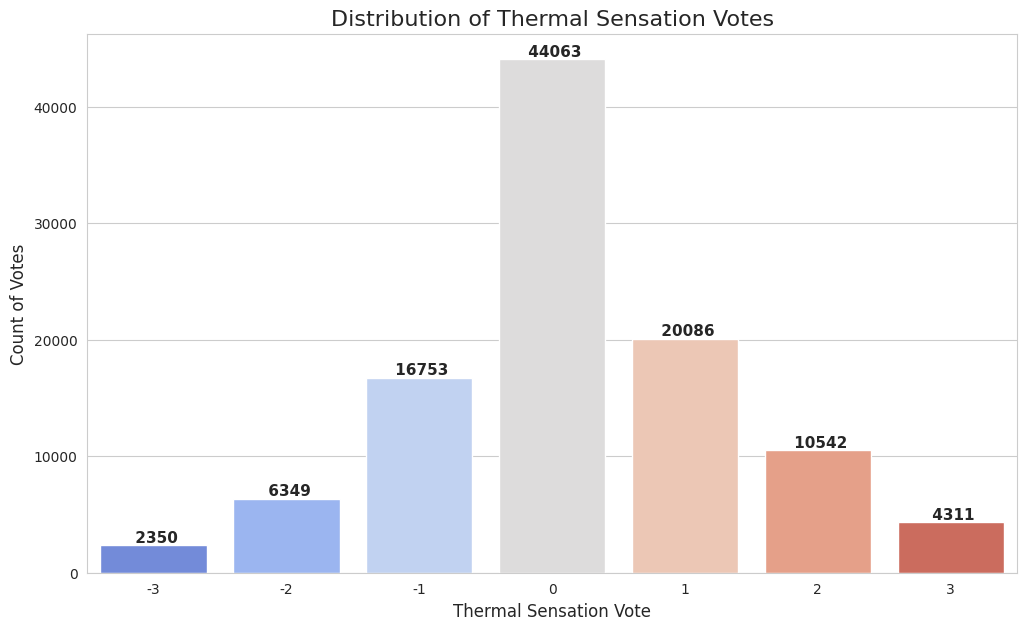

In [ ]:
# Manually count the occurrences of each sensation vote
sensation_counts = df_cleaned['thermal_sensation'].round().value_counts()

# Reindex the counts to ensure the order is from -3 to +3.
sensation_counts = sensation_counts.reindex([-3, -2, -1, 0, 1, 2, 3], fill_value=0)

# Create the plot using barplot for precise control
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Use barplot, which plots the x and y values we provide directly.
ax = sns.barplot(
    x=sensation_counts.index,
    y=sensation_counts.values,
    palette='coolwarm'
)

# Add clear data labels on top of each bar
for i, count in enumerate(sensation_counts.values):
    ax.text(
        i,                      # x-position (the i-th bar)
        count,                  # y-position (the height of the bar)
        f' {int(count)}',       # The text to display (the count)
        ha='center',            # Horizontal alignment
        va='bottom',            # Vertical alignment
        fontsize=11,
        fontweight='bold'
    )

# Add final titles and labels for a professional look
plt.title('Distribution of Thermal Sensation Votes', fontsize=16)
plt.xlabel('Thermal Sensation Vote', fontsize=12)
plt.ylabel('Count of Votes', fontsize=12)
# Set clear labels for the x-axis ticks
plt.xticks(
    ticks=range(7),
    labels=['-3', '-2', '-1', '0', '1', '2', '3']
)

# Show the plot
plt.show()

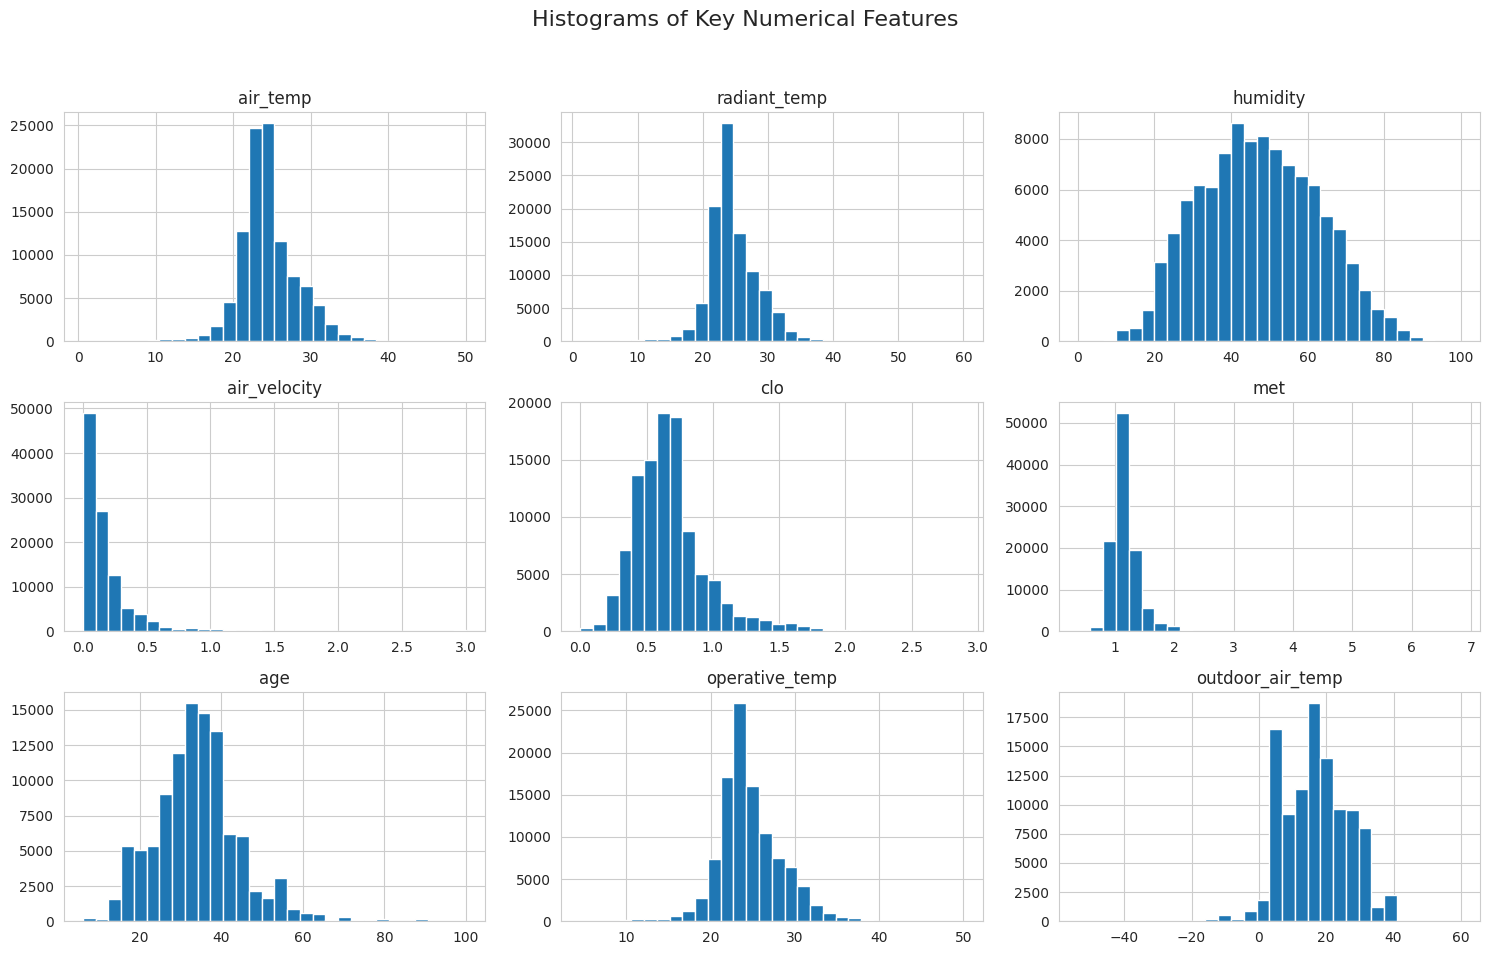

In [ ]:
# Select key numerical features for plotting
numerical_features = [
    'air_temp', 'radiant_temp', 'humidity',
    'air_velocity', 'clo', 'met', 'age', 'operative_temp',
    'outdoor_air_temp'
]

# Increase the layout to accommodate all 9 histograms
df_cleaned[numerical_features].hist(bins=30, figsize=(15, 10), layout=(3, 3))
plt.suptitle('Histograms of Key Numerical Features', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for the title
plt.show()

---
##Exploring Relationships Between Variables
1. Correlation Matrix Heatmap : to see the linear relationships between all numerical variables at once.

2. Box Plots: Categorical Features vs. Thermal Sensation

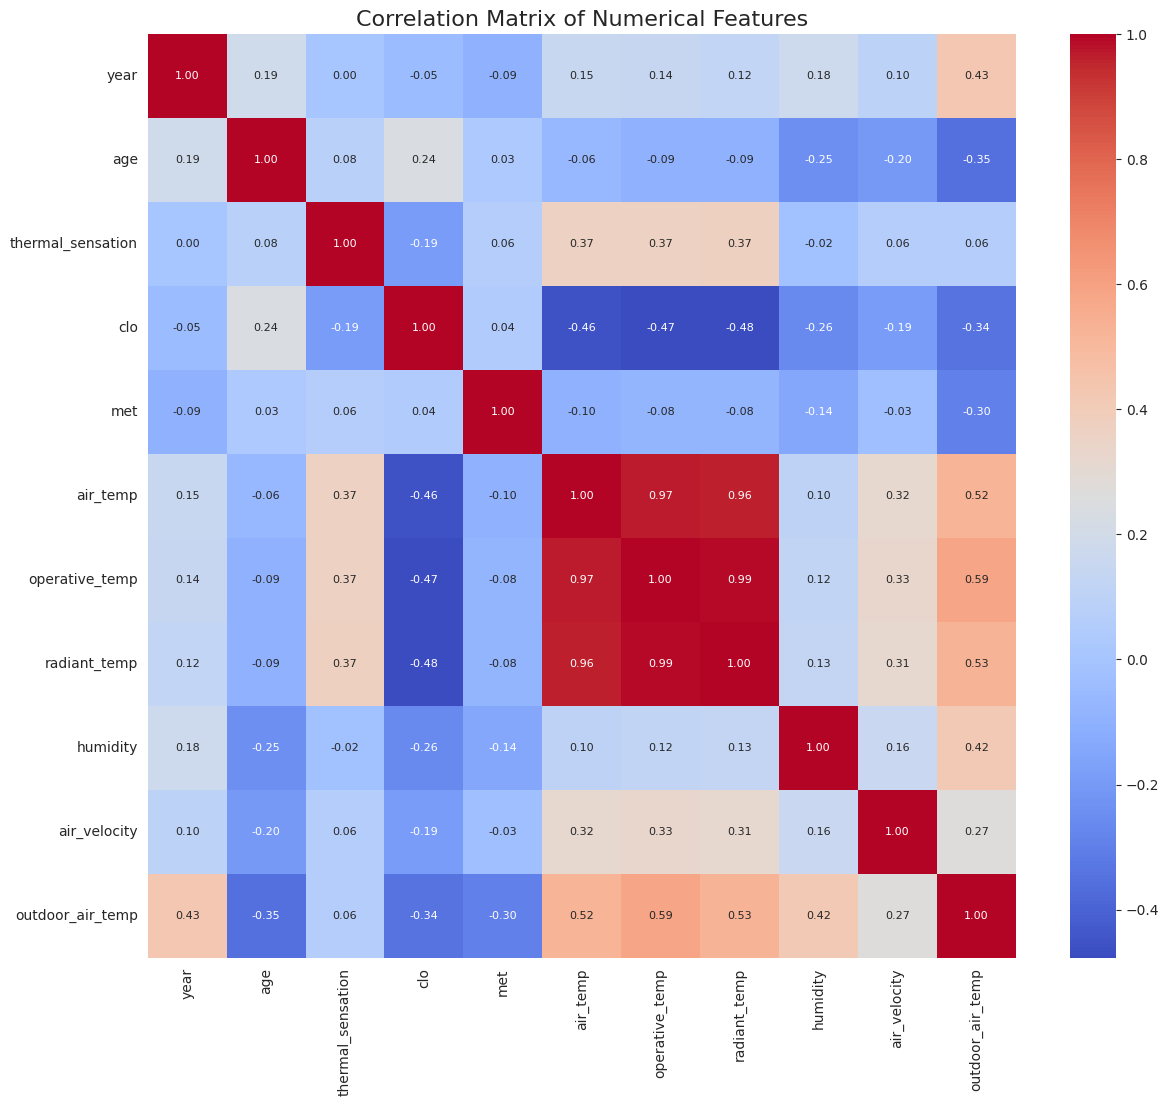

In [ ]:
plt.figure(figsize=(14, 12))

# Select all numerical columns for the correlation matrix
all_numerical_cols = df_cleaned.select_dtypes(include=['float64', 'int64'])
corr_matrix = all_numerical_cols.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()

/tmp/ipython-input-782213708.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='thermal_sensation', data=df_cleaned, ax=axes[i], palette='viridis')
/tmp/ipython-input-782213708.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='thermal_sensation', data=df_cleaned, ax=axes[i], palette='viridis')
/tmp/ipython-input-782213708.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='thermal_sensation', data=df_cleaned, ax=axes[i], palette='viridis')
/tmp/ipython-input-782213708.py:15: FutureWarning: 

Passing `palet

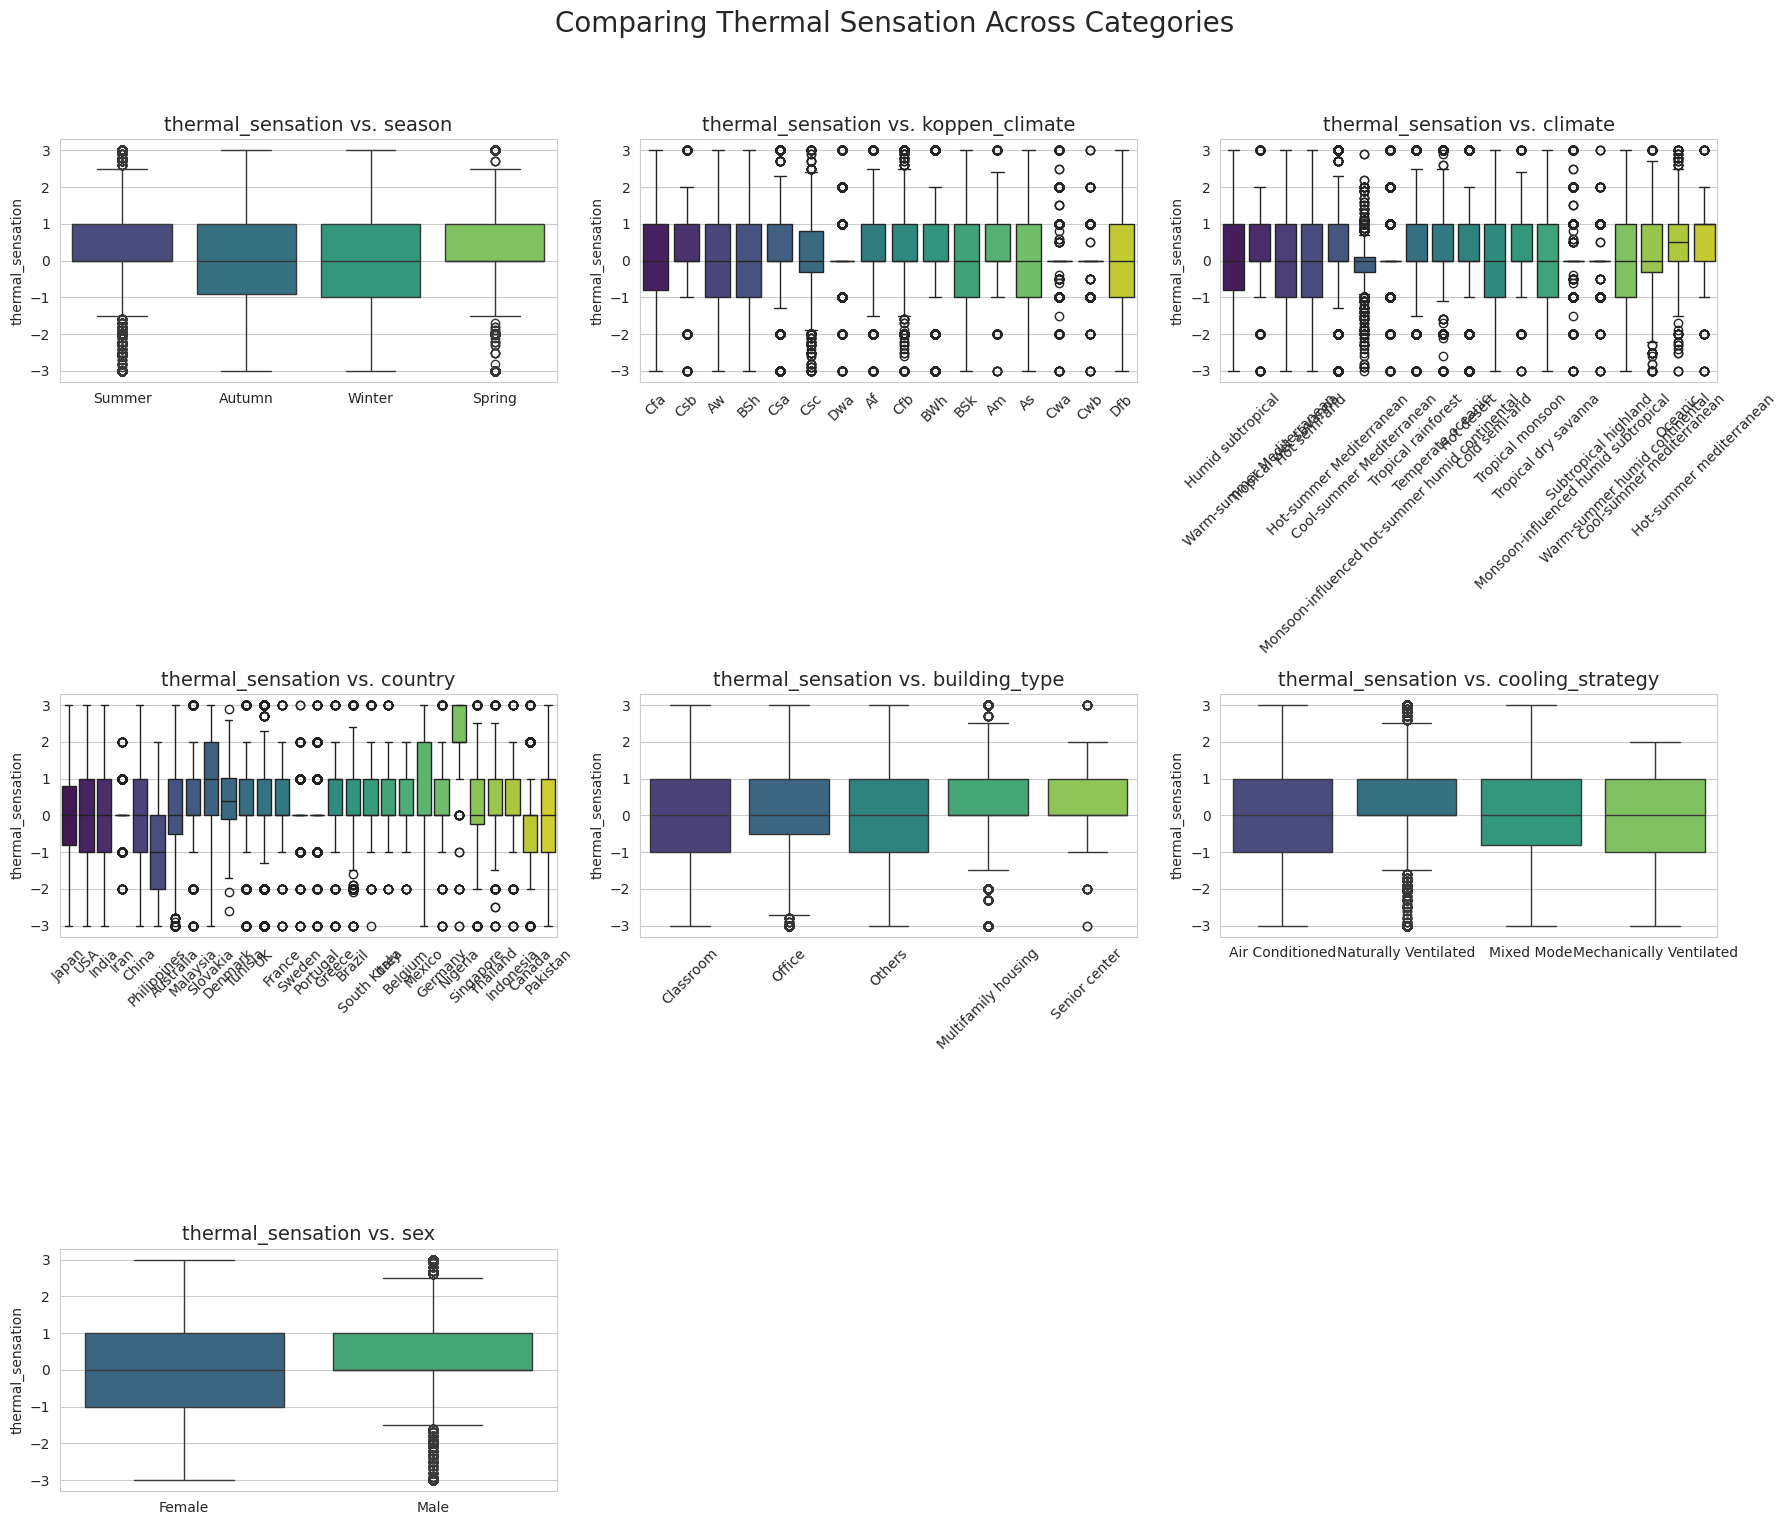

In [ ]:
# List of key categorical features to analyze
categorical_features_to_plot = ['season', 'koppen_climate', 'climate', 'country', 'building_type',
                                'cooling_strategy', 'sex']

# Create a figure with subplots - increased to 3x3 for 9 plots
fig, axes = plt.subplots(3, 3, figsize=(18, 16)) # Adjusted figsize
axes = axes.flatten() # Flatten the 3x3 array of axes for easy iteration

# Remove any unused axes from the flattened array to avoid plotting on them
# There are 9 axes in a 3x3 layout, but only 7 features to plot.
for j in range(len(categorical_features_to_plot), len(axes)):
    fig.delaxes(axes[j]) # Remove the extra axes

for i, col in enumerate(categorical_features_to_plot):
    sns.boxplot(x=col, y='thermal_sensation', data=df_cleaned, ax=axes[i], palette='viridis')
    axes[i].set_title(f'thermal_sensation vs. {col}', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('thermal_sensation')
    # Rotate x-axis labels if they are long
    if len(df_cleaned[col].unique()) > 4:
        axes[i].tick_params(axis='x', rotation=45)

plt.suptitle('Comparing Thermal Sensation Across Categories', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

thermal_sensation vs. country

Observation: This plot is very crowded and difficult to read, which is an important finding in itself. There are dramatic differences between countries; for instance, the median sensation in Nigeria and Mexico appears much higher than in the UK or Sweden.

Interpretation: While Country is clearly a powerful predictor, it has two major problems for modeling:

High Cardinality: There are too many unique categories, which can make our models overly complex and prone to overfitting.

Redundancy: Its information largely overlaps with koppen_climate.

Recommendation: For the models, it would be wise to drop the country column and use koppen_climate as our primary geographical feature. This will make the model simpler and more generalizable.

## Final Feature Selection

In [ ]:
df_cleaned.columns

Index(['year', 'season', 'koppen_climate', 'climate', 'country',
       'building_type', 'cooling_strategy', 'age', 'sex', 'thermal_sensation',
       'clo', 'met', 'air_temp', 'operative_temp', 'radiant_temp', 'humidity',
       'air_velocity', 'outdoor_air_temp'],
      dtype='object')

In [ ]:
# These are the columns we will drop based on our analysis
columns_to_drop = [
    'air_temp',
    'radiant_temp',
    'country',
    'year',
    'climate'
]

# Create the final model-ready dataframe
df_model = df_cleaned.drop(columns=columns_to_drop)

# the target variable should be rounded to integers
# Before converting to integer, ensure there are no  infinite values.

df_model.replace([np.inf, -np.inf], np.nan, inplace=True) # Replace any infinite values with NaN

#  Drop any rows where the target variable is now NaN
initial_rows = len(df_model)
df_model.dropna(subset=['thermal_sensation'], inplace=True)
final_rows = len(df_model)

if initial_rows != final_rows:
    print(f"Dropped {initial_rows - final_rows} rows with non-finite target values.")


# convert to integer
df_model['thermal_sensation'] = df_model['thermal_sensation'].round().astype(int)



print("\nFinal features for modeling:")
print(df_model.columns.tolist())

print(f"\nShape of the final modeling DataFrame: {df_model.shape}")
print(f"Data type of target variable: {df_model['thermal_sensation'].dtype}")
print("\n")
print(df_model.columns)


Final features for modeling:
['season', 'koppen_climate', 'building_type', 'cooling_strategy', 'age', 'sex', 'thermal_sensation', 'clo', 'met', 'operative_temp', 'humidity', 'air_velocity', 'outdoor_air_temp']

Shape of the final modeling DataFrame: (104454, 13)
Data type of target variable: int64


Index(['season', 'koppen_climate', 'building_type', 'cooling_strategy', 'age',
       'sex', 'thermal_sensation', 'clo', 'met', 'operative_temp', 'humidity',
       'air_velocity', 'outdoor_air_temp'],
      dtype='object')


---
### Define Features (X) and Target (y)

Separate the dataset into the predictor variables (X) and the target variable we want to predict (y)

---

In [ ]:
# X contains all columns EXCEPT the target variable
X = df_model.drop(columns=['thermal_sensation'])

# y contains ONLY the target variable
y = df_model['thermal_sensation']

### Split Data into Training and Testing Sets 80 : 20

Split the data, typically with an 80/20 or 70/30 ratio

stratify=y is CRUCIAL here. It ensures that the distribution of the 'thermal_sensation' classes
is the same in both the training and testing sets, which is vital for an imbalanced dataset.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% of the data will be used for testing
    random_state=42,    # Ensures the split is the same every time you run the code
    stratify=y          # <<< Very important for imbalanced classification!
)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (83563, 12)
Shape of X_test: (20891, 12)


---
###Preprocessing (Encoding & Scaling) and Handling Imbalance

One-Hot Encode the categorical features.

Scale the numerical features .

Handle the Class Imbalance using an oversampling technique like SMOTE.

---

In [ ]:
# Identify which columns are numerical and which are categorical
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create the preprocessing pipeline using ColumnTransformer
# This applies different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features), # Scale numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features) # One-hot encode categorical features
    ],
    remainder='passthrough' # Keep other columns (if any)
)

# --- Apply the preprocessing and SMOTE ---

# 1. Fit the preprocessor on the TRAINING data and transform it
X_train_processed = preprocessor.fit_transform(X_train)

# 2. Transform the TESTING data using the SAME preprocessor fitted on the training data
X_test_processed = preprocessor.transform(X_test)

print("Preprocessing complete.")
print(f"Shape of X_train after processing: {X_train_processed.shape}") # Note the increased number of columns from OHE

# 3. Apply SMOTE to the PROCESSED TRAINING data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

print("\nSMOTE applied to the training data.")
print(f"Shape of X_train after SMOTE: {X_train_resampled.shape}")
print("\nDistribution of classes in the target variable before and after SMOTE:")
print("Before SMOTE:\n", y_train.value_counts().sort_index())
print("\nAfter SMOTE:\n", y_train_resampled.value_counts().sort_index())

Preprocessing complete.
Shape of X_train after processing: (83563, 38)

SMOTE applied to the training data.
Shape of X_train after SMOTE: (246750, 38)

Distribution of classes in the target variable before and after SMOTE:
Before SMOTE:
 thermal_sensation
-3     1880
-2     5079
-1    13402
 0    35250
 1    16069
 2     8434
 3     3449
Name: count, dtype: int64

After SMOTE:
 thermal_sensation
-3    35250
-2    35250
-1    35250
 0    35250
 1    35250
 2    35250
 3    35250
Name: count, dtype: int64


/tmp/ipython-input-2598739094.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


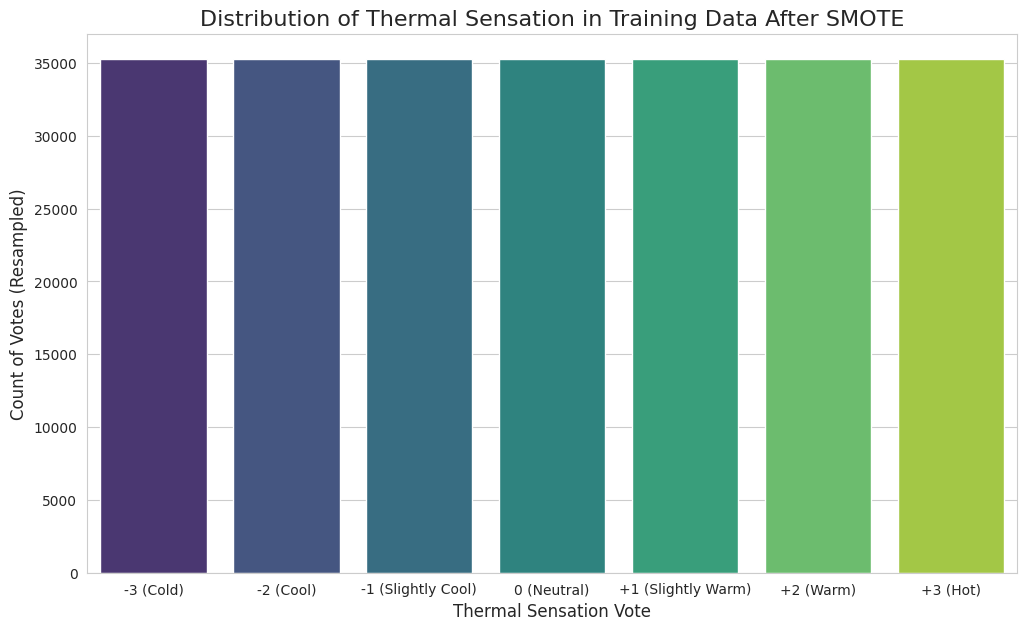

In [ ]:
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Create the count plot on the RESAMPLED data
ax = sns.countplot(
    x=y_train_resampled,
    order=[-3, -2, -1, 0, 1, 2, 3],
    palette='viridis' # Use a different palette to distinguish it
)

plt.title('Distribution of Thermal Sensation in Training Data After SMOTE', fontsize=16)
plt.xlabel('Thermal Sensation Vote', fontsize=12)
plt.ylabel('Count of Votes (Resampled)', fontsize=12)
plt.xticks(
    ticks=range(7),
    labels=['-3 (Cold)', '-2 (Cool)', '-1 (Slightly Cool)', '0 (Neutral)', '+1 (Slightly Warm)', '+2 (Warm)', '+3 (Hot)']
)
plt.show()

---
## Logistic Regression

---

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Training complete.

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

          -3       0.08      0.67      0.14       470
          -2       0.15      0.29      0.20      1270
          -1       0.24      0.24      0.24      3351
           0       0.60      0.23      0.33      8813
           1       0.25      0.09      0.13      4017
           2       0.18      0.23      0.20      2108
           3       0.14      0.60      0.23       862

    accuracy                           0.23     20891
   macro avg       0.23      0.34      0.21     20891
weighted avg       0.37      0.23      0.25     20891


Displaying Confusion Matrix...


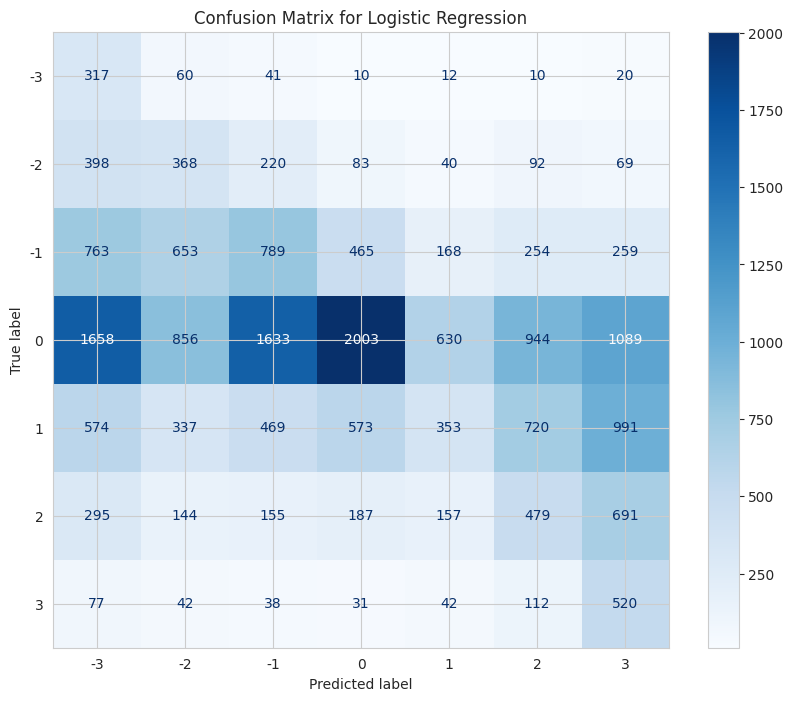

In [ ]:
# Initialize and Train the Model
lr_model = LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42)

# Fit the model on the BALANCED training data
lr_model.fit(X_train_resampled, y_train_resampled)
print("Training complete.")

# 2. Make Predictions on the Test Set
y_pred_lr = lr_model.predict(X_test_processed)


#  3. Evaluate the Model's Performance

# a) Classification Report
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_lr))


# b) Confusion Matrix
print("\nDisplaying Confusion Matrix...")
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_lr,
    ax=ax,
    cmap='Blues',
    normalize=None # 'true' or 'pred' to see percentages instead of counts
)
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

---
##Random Forest
n_estimators is the number of trees in the forest.
n_jobs=-1 uses all available CPU cores to speed up training.
---

Training complete.

Classification Report for Random Forest:
              precision    recall  f1-score   support

          -3       0.43      0.50      0.46       470
          -2       0.34      0.42      0.38      1270
          -1       0.43      0.44      0.43      3351
           0       0.66      0.64      0.65      8813
           1       0.46      0.44      0.45      4017
           2       0.45      0.45      0.45      2108
           3       0.48      0.53      0.51       862

    accuracy                           0.53     20891
   macro avg       0.46      0.49      0.48     20891
weighted avg       0.53      0.53      0.53     20891


Displaying Confusion Matrix...


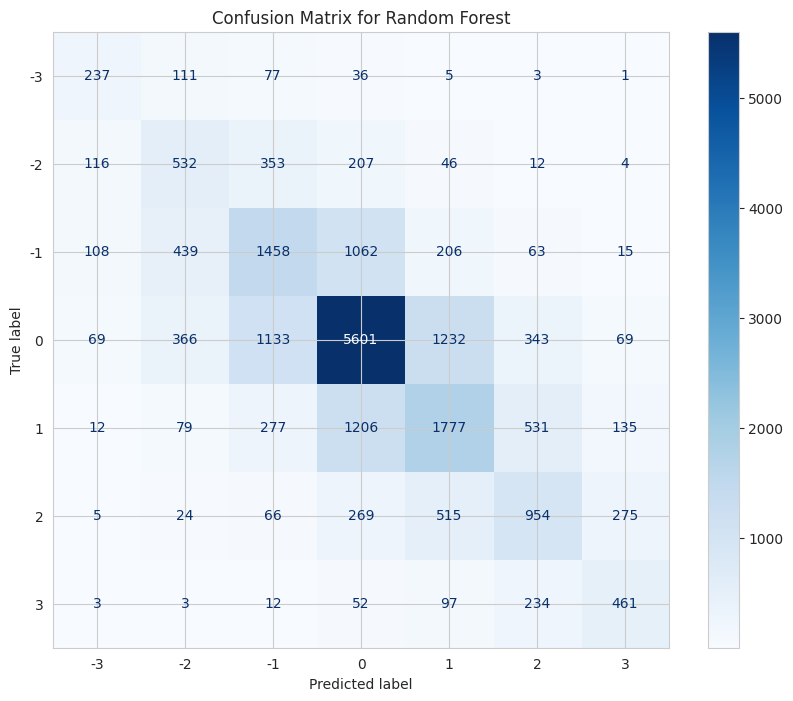

In [ ]:
# 1. Initialize and Train the Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Fit the model on the SAME BALANCED training data
rf_model.fit(X_train_resampled, y_train_resampled)
print("Training complete.")

# 2. Make Predictions on the Test Set
y_pred_rf = rf_model.predict(X_test_processed)


# 3. Evaluate the Model's Performance

# a) Classification Report
print("\nClassification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))


# b) Confusion Matrix
print("\nDisplaying Confusion Matrix...")
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_rf,
    ax=ax,
    cmap='Blues',
    normalize=None
)
plt.title("Confusion Matrix for Random Forest")
plt.show()

## XGBoost
Transform our y labels (-3 to +3) into (0 to 6) for XGBoost to work and  transform the predictions back to the original labels (-3 to +3) for evaluation
'objective':'multi:softmax' tells XGBoost this is a multi-class classification problem.

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:56:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training complete.

Classification Report for XGBoost:
              precision    recall  f1-score   support

          -3       0.26      0.53      0.34       470
          -2       0.27      0.39      0.32      1270
          -1       0.38      0.30      0.33      3351
           0       0.60      0.58      0.59      8813
           1       0.41      0.28      0.34      4017
           2       0.35      0.42      0.38      2108
           3       0.32      0.60      0.42       862

    accuracy                           0.45     20891
   macro avg       0.37      0.44      0.39     20891
weighted avg       0.46      0.45      0.45     20891


Displaying Confusion Matrix...


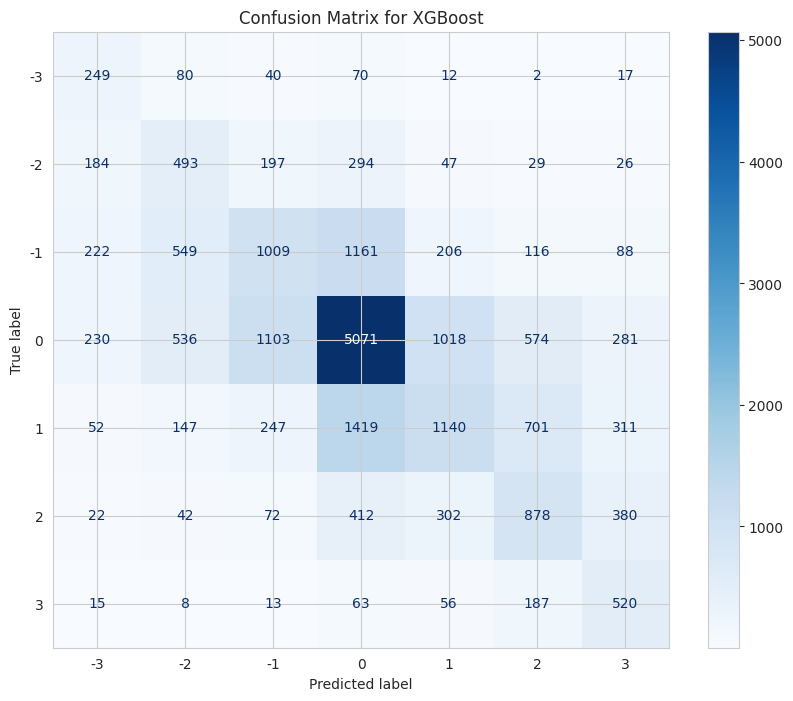

In [ ]:
le = LabelEncoder()
y_train_resampled_xgb = le.fit_transform(y_train_resampled)
y_test_xgb = le.transform(y_test)

# 1. Initialize and Train the Model
# 'num_class': 7 tells it how many classes there are.
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=7, random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='mlogloss')
# Fit the model on the balanced training data with encoded labels
xgb_model.fit(X_train_resampled, y_train_resampled_xgb)
print("Training complete.")


# 2. Make Predictions on the Test Set
y_pred_xgb_encoded = xgb_model.predict(X_test_processed)

# transform the predictions back to the original labels
y_pred_xgb = le.inverse_transform(y_pred_xgb_encoded)

# --- 3. Evaluate the Model's Performance ---

# a) Classification Report
print("\nClassification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb))


# b) Confusion Matrix
print("\nDisplaying Confusion Matrix...")
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_xgb,
    ax=ax,
    cmap='Blues',
    normalize=None
)
plt.title("Confusion Matrix for XGBoost")
plt.show()


##Support Vector Machine (SVM)
This is a very slow process due to a large dataset

Training the Support Vector Machine (SVM) model...
Training complete.

Classification Report for Support Vector Machine (SVM):
              precision    recall  f1-score   support

          -3       0.19      0.64      0.29       470
          -2       0.18      0.44      0.26      1270
          -1       0.30      0.31      0.31      3351
           0       0.66      0.32      0.43      8813
           1       0.36      0.28      0.32      4017
           2       0.26      0.41      0.32      2108
           3       0.24      0.65      0.35       862

    accuracy                           0.35     20891
   macro avg       0.32      0.44      0.33     20891
weighted avg       0.45      0.35      0.36     20891


Displaying Confusion Matrix...


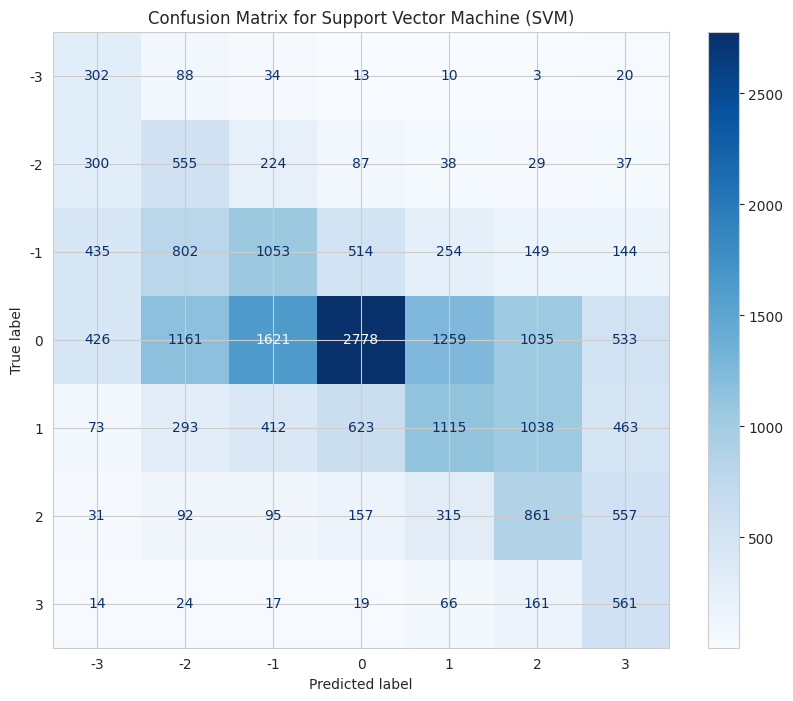

In [ ]:
# 1. Initialize and Train the Model
svm_model = SVC(random_state=42, decision_function_shape='ovr')

print("Training the Support Vector Machine (SVM) model...")

# Fit the model on the BALANCED training data
svm_model.fit(X_train_resampled, y_train_resampled)
print("Training complete.")


# --- 2. Make Predictions on the Test Set ---
# Predict on the UNSEEN, IMBALANCED test data
y_pred_svm = svm_model.predict(X_test_processed)


# --- 3. Evaluate the Model's Performance ---

# a) Classification Report
print("\nClassification Report for Support Vector Machine (SVM):")
print(classification_report(y_test, y_pred_svm))


# b) Confusion Matrix
print("\nDisplaying Confusion Matrix...")
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_svm,
    ax=ax,
    cmap='Blues',
    normalize=None
)
plt.title("Confusion Matrix for Support Vector Machine (SVM)")
plt.show()

## Deep Neural Network (DNN)

Neural Networks need labels to be 0, 1, 2...
The LabelEncoder from the XGBoost step will be reused.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,703 (53.53 KB)

 Trainable params: 13,703 (53.53 KB)

 Non-trainable params: 0 (0.00 B)


Training the Deep Neural Network model...
Epoch 1/20
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.2894 - loss: 1.7157 - val_accuracy: 0.0091 - val_loss: 2.1819
Epoch 2/20
868/868 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3596 - loss: 1.5534 - val_accuracy: 0.0798 - val_loss: 1.9389
Epoch 3/20
868/868 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3902 - loss: 1.4795 - val_accuracy: 0.0481 - val_loss: 1.9056
Epoch 4/20
868/868 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.4181 - loss: 1.3997 - val_accuracy: 0.0429 - val_loss: 1.8271
Epoch 5/20
868/868 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4411 - loss: 1.3438 - val_accuracy: 0.1085 - val_loss: 1.6973
Epoch 6/20
868/868 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4537 - loss: 1.3076 - val_accuracy: 0.0775 - val_loss: 1.6901
Epoch 7/20
868/868 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4637 - loss: 1.2812 - val_accuracy: 0.1079 - val_loss: 1.6520
Epoch 8/20
868/868 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accurac

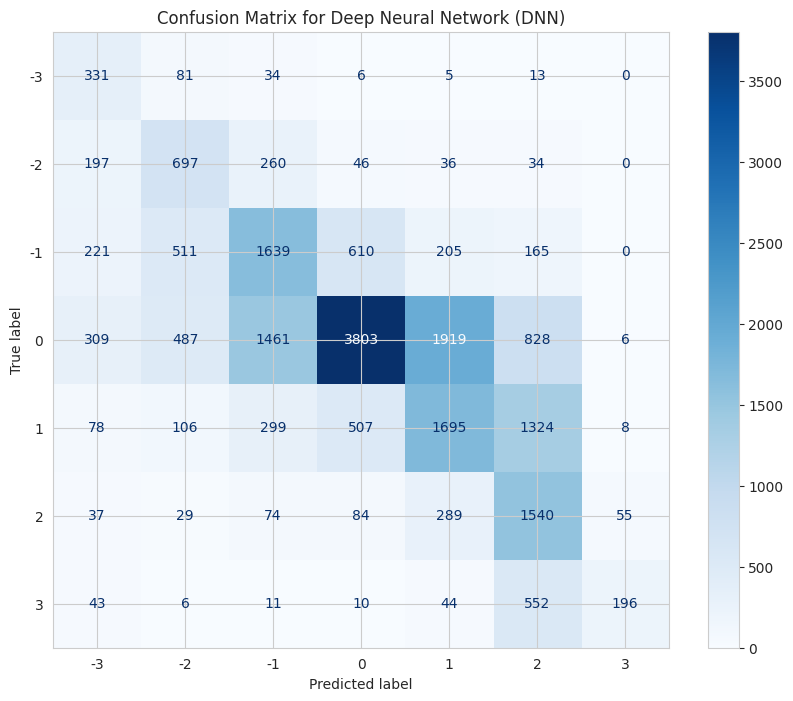

In [ ]:
# For clarity rename the variables for this model
y_train_dnn = le.fit_transform(y_train_resampled)
y_test_dnn = le.transform(y_test)

# 1. Define the DNN Architecture
n_features = X_train_resampled.shape[1] # The number of input features (should be 38)
n_classes = len(np.unique(y_train_dnn)) # The number of output classes (should be 7)

dnn_model = keras.Sequential([
    # Input layer - matches the number of features
    layers.Input(shape=(n_features,)),
    # Hidden layer 1 - 128 neurons, 'relu' is a standard activation function
    layers.Dense(128, activation='relu'),
    # Dropout layer - helps prevent overfitting by randomly "turning off" neurons during training
    layers.Dropout(0.3),
    # Hidden layer 2 - 64 neurons
    layers.Dense(64, activation='relu'),
    # Dropout layer
    layers.Dropout(0.3),
    # Output layer - must have one neuron per class.
    # 'softmax' ensures the output is a probability distribution across the classes.
    layers.Dense(n_classes, activation='softmax')
])

# Compile the Model

dnn_model.compile(
    optimizer='adam', # Adam is a popular, effective optimizer
    loss='sparse_categorical_crossentropy', # The correct loss function for integer-based multi-class classification
    metrics=['accuracy'] # We want to track accuracy during training
)

dnn_model.summary() # Print a summary of the model architecture


# Train the Model
print("\nTraining the Deep Neural Network model...")
history = dnn_model.fit(
    X_train_resampled,
    y_train_dnn,
    epochs=20, # The number of times to go through the entire training dataset
    batch_size=256, # The number of samples to work through before updating model weights
    validation_split=0.1, # Use 10% of training data for validation during training
    verbose=1 # Show progress
)
print("Training complete.")


#  Make Predictions on the Test Set
# The model outputs probabilities for each class, so we take the one with the highest probability.
y_pred_dnn_encoded = np.argmax(dnn_model.predict(X_test_processed), axis=-1)

# transform the predictions back to the original labels (-3 to +3)
y_pred_dnn = le.inverse_transform(y_pred_dnn_encoded)


# 5. Evaluate the Model's Performance
print("\nClassification Report for Deep Neural Network (DNN):")
print(classification_report(y_test, y_pred_dnn))

print("\nDisplaying Confusion Matrix...")
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_dnn,
    ax=ax,
    cmap='Blues'
)
plt.title("Confusion Matrix for Deep Neural Network (DNN)")
plt.show()

---
---
 ## Hyperparameter Tuning for Random Forest

 ---

Fitting RandomizedSearchCV... This will take a significant amount of time.
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting complete.

Best hyperparameters found:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}

--- Evaluating the Tuned Random Forest Model ---

Classification Report for Tuned Random Forest:
              precision    recall  f1-score   support

          -3       0.44      0.51      0.47       470
          -2       0.35      0.42      0.38      1270
          -1       0.43      0.43      0.43      3351
           0       0.67      0.64      0.65      8813
           1       0.46      0.45      0.45      4017
           2       0.44      0.46      0.45      2108
           3       0.49      0.54      0.52       862

    accuracy                           0.53     20891
   macro avg       0.47      0.49      0.48     20891
weighted avg       0.54      0.53      0.53     20891



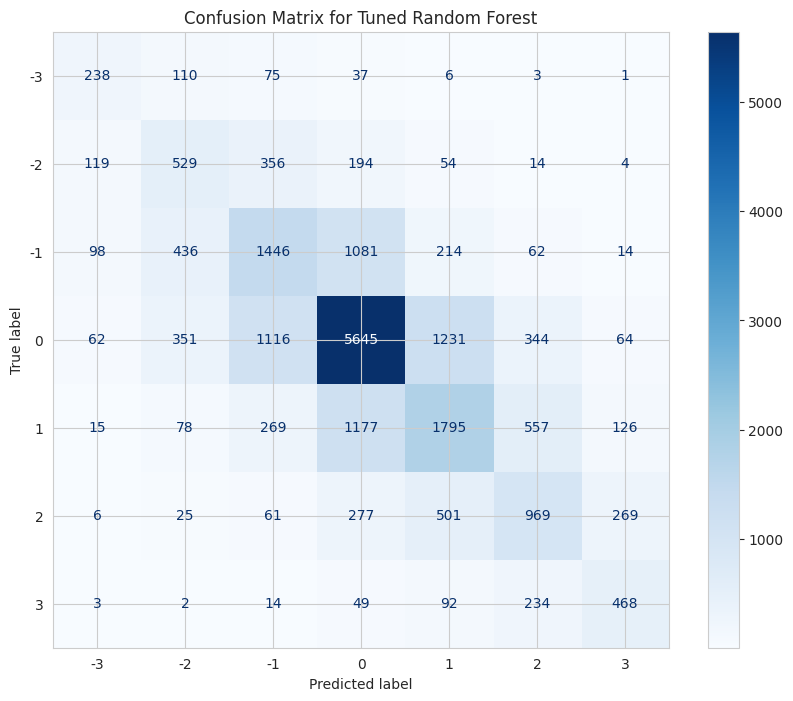

In [ ]:
# 1. Define the hyperparameter grid
param_dist_rf = {
    'n_estimators': [int(x) for x in range(200, 1000, 200)], # Number of trees in the forest
    'max_depth': [10, 20, 30, None], # Maximum depth of the tree (None = no limit)
    'min_samples_split': [2, 5, 10], # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4], # Minimum number of samples required at a leaf node
    'max_features': ['sqrt', 'log2'] # Number of features to consider when looking for the best split
}

# 2. Set up RandomizedSearchCV
# This will test 'n_iter' different random combinations from our grid using 3-fold cross-validation.
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=20, # Number of parameter settings that are sampled. Increase for better results, decrease for speed.
    cv=3, # 3-fold cross-validation
    verbose=2, # Prints progress
    random_state=42,
    n_jobs=-1 # Use all available cores
)

# 3. Fit the random search model
print("Fitting RandomizedSearchCV... This will take a significant amount of time.")
# We fit on the resampled (balanced) training data
rf_random_search.fit(X_train_resampled, y_train_resampled)
print("Fitting complete.")

# 4. Get the best parameters and the best model
print("\nBest hyperparameters found:")
print(rf_random_search.best_params_)
best_rf_model = rf_random_search.best_estimator_

# 5. Evaluate the *tuned* model on the test set
print("\n--- Evaluating the Tuned Random Forest Model ---")
y_pred_rf_tuned = best_rf_model.predict(X_test_processed)
print("\nClassification Report for Tuned Random Forest:")
print(classification_report(y_test, y_pred_rf_tuned))

# Display the confusion matrix for the tuned model
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_tuned, ax=ax, cmap='Blues')
plt.title("Confusion Matrix for Tuned Random Forest")
plt.show()

---
## Hyperparameter Tuning for XGBoost

---


--- Starting Hyperparameter Tuning for XGBoost ---
Fitting RandomizedSearchCV for XGBoost... This will also take a long time.
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:38:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting complete.

Best hyperparameters found:
{'subsample': 1.0, 'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

--- Evaluating the Tuned XGBoost Model ---

Classification Report for Tuned XGBoost:
              precision    recall  f1-score   support

          -3       0.47      0.47      0.47       470
          -2       0.39      0.39      0.39      1270
          -1       0.44      0.38      0.41      3351
           0       0.62      0.69      0.65      8813
           1       0.47      0.39      0.43      4017
           2       0.46      0.45      0.45      2108
           3       0.44      0.51      0.47       862

    accuracy                           0.53     20891
   macro avg       0.47      0.47      0.47     20891
weighted avg       0.52      0.53      0.52     20891



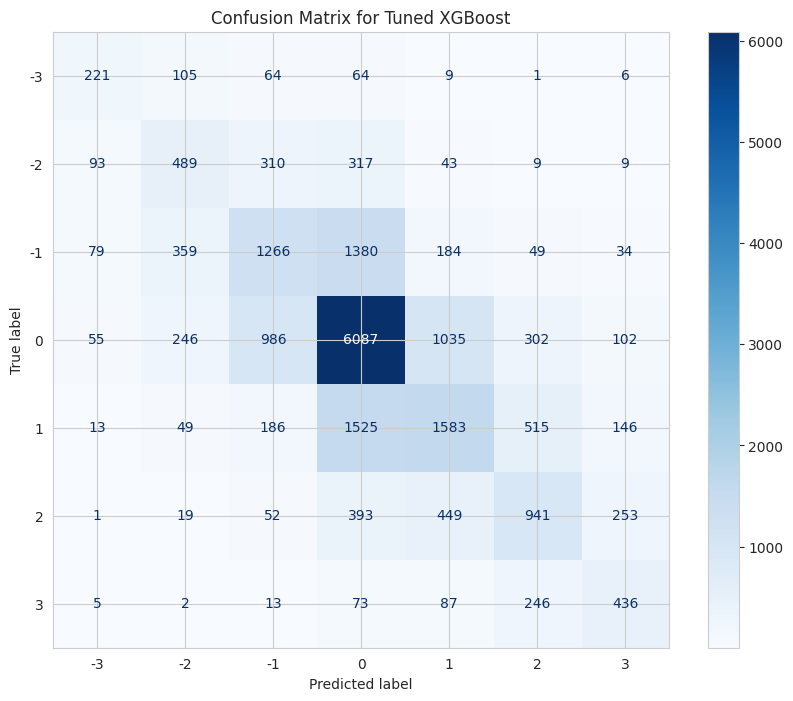

In [ ]:
print("\n--- Starting Hyperparameter Tuning for XGBoost ---")

# Remember to use the encoded labels (0-6) for XGBoost
le = LabelEncoder()
y_train_resampled_xgb = le.fit_transform(y_train_resampled)
y_test_xgb = le.transform(y_test)

# 1. Define the hyperparameter grid
param_dist_xgb = {
    'n_estimators': [int(x) for x in range(200, 1000, 200)],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0], # Fraction of training instances to be used for growing trees
    'colsample_bytree': [0.7, 0.8, 1.0] # Subsample ratio of columns when constructing each tree
}

# 2. Set up RandomizedSearchCV
xgb_random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(objective='multi:softmax', num_class=7, random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    param_distributions=param_dist_xgb,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 3. Fit the random search model
print("Fitting RandomizedSearchCV for XGBoost... This will also take a long time.")
xgb_random_search.fit(X_train_resampled, y_train_resampled_xgb)
print("Fitting complete.")

# 4. Get the best parameters and the best model
print("\nBest hyperparameters found:")
print(xgb_random_search.best_params_)
best_xgb_model = xgb_random_search.best_estimator_

# 5. Evaluate the *tuned* model
print("\n--- Evaluating the Tuned XGBoost Model ---")
y_pred_xgb_tuned_encoded = best_xgb_model.predict(X_test_processed)
# Transform predictions back to original labels (-3 to +3)
y_pred_xgb_tuned = le.inverse_transform(y_pred_xgb_tuned_encoded)

print("\nClassification Report for Tuned XGBoost:")
print(classification_report(y_test, y_pred_xgb_tuned))

fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb_tuned, ax=ax, cmap='Blues')
plt.title("Confusion Matrix for Tuned XGBoost")
plt.show()

---
 ## Hyperparameter Tuning for Deep Neural Network (DNN)

 ---

In [ ]:
!pip install keras_tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

Trial 10 Complete [00h 02m 57s]
val_accuracy: 0.08526849001646042

Best val_accuracy So Far: 0.17614994943141937
Total elapsed time: 00h 35m 53s
Search complete.

Best hyperparameters found:
- Number of layers: 3
- Learning rate: 0.001
- (Specific units and dropout rates will also be in the HPs object)


--- Evaluating the Tuned Deep Neural Network Model ---
 46/653 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


653/653 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Classification Report for Tuned DNN:
              precision    recall  f1-score   support

          -3       0.28      0.71      0.40       470
          -2       0.31      0.60      0.41      1270
          -1       0.43      0.44      0.44      3351
           0       0.75      0.40      0.52      8813
           1       0.37      0.65      0.47      4017
           2       0.47      0.47      0.47      2108
           3       0.00      0.00      0.00       862

    accuracy                           0.46     20891
   macro avg       0.37      0.47      0.39     20891
weighted avg       0.53      0.46      0.46     20891



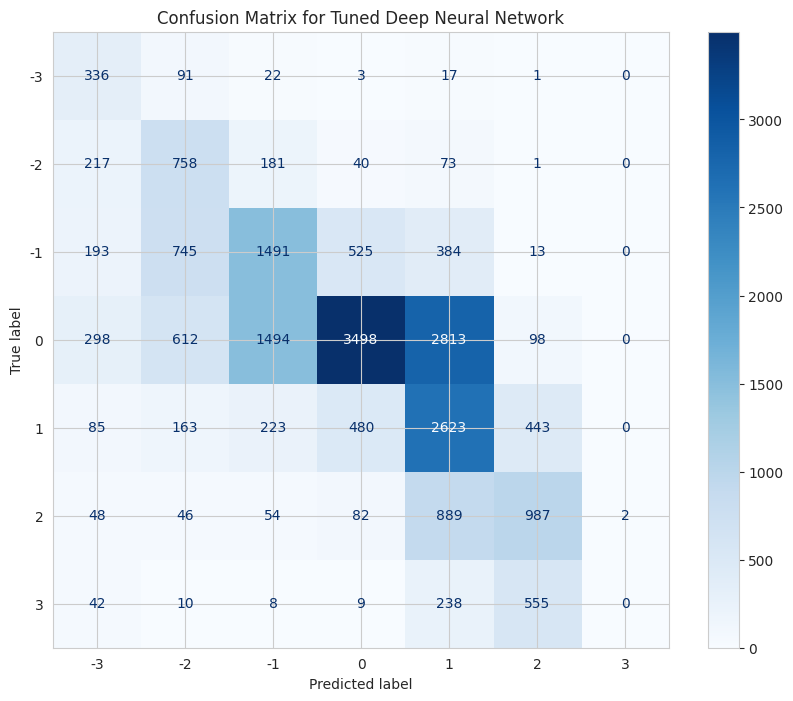

In [ ]:
print("\n--- Starting Hyperparameter Tuning for Deep Neural Network ---")

# Use the encoded labels (0-6)
# le = LabelEncoder() # This is already imported and used before
y_train_dnn = le.fit_transform(y_train_resampled)
y_test_dnn = le.transform(y_test)

# 1. Define the model-building function that Keras Tuner will use
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(X_train_resampled.shape[1],)))

    # Tune the number of hidden layers and units per layer
    for i in range(hp.Int('num_layers', 1, 3)): # Tune between 1 and 3 hidden layers
        model.add(keras.layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            activation='relu'
        ))
        model.add(keras.layers.Dropout(hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1)))

    model.add(keras.layers.Dense(7, activation='softmax')) # 7 output classes

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 2. Instantiate the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10, # Number of model configurations to test.
    executions_per_trial=1, # Number of models to train for each trial.
    directory='my_dir',
    project_name='thermal_comfort_tuning'
)

# 3. Run the hyperparameter search
print("Running Keras Tuner search... This is the slowest step and can take hours.")
# Note: Keras Tuner handles its own validation split from the training data.
tuner.search(X_train_resampled, y_train_dnn, epochs=10, validation_split=0.2)
print("Search complete.")

# 4. Get the optimal hyperparameters and the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best hyperparameters found:
- Number of layers: {best_hps.get('num_layers')}
- Learning rate: {best_hps.get('learning_rate')}
- (Specific units and dropout rates will also be in the HPs object)
""")
best_dnn_model = tuner.get_best_models(num_models=1)[0]


# 5. Evaluate the *tuned* DNN model
print("\n--- Evaluating the Tuned Deep Neural Network Model ---")
y_pred_dnn_tuned_encoded = np.argmax(best_dnn_model.predict(X_test_processed), axis=-1)
y_pred_dnn_tuned = le.inverse_transform(y_pred_dnn_tuned_encoded)

print("\nClassification Report for Tuned DNN:")
print(classification_report(y_test, y_pred_dnn_tuned))

fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dnn_tuned, ax=ax, cmap='Blues')
plt.title("Confusion Matrix for Tuned Deep Neural Network")
plt.show()

---
## Feature Importance Analysis

Getting Feature Names After One-Hot Encoding

---

/tmp/ipython-input-41-3623719962.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importances.values, y=rf_importances.index, palette='viridis')


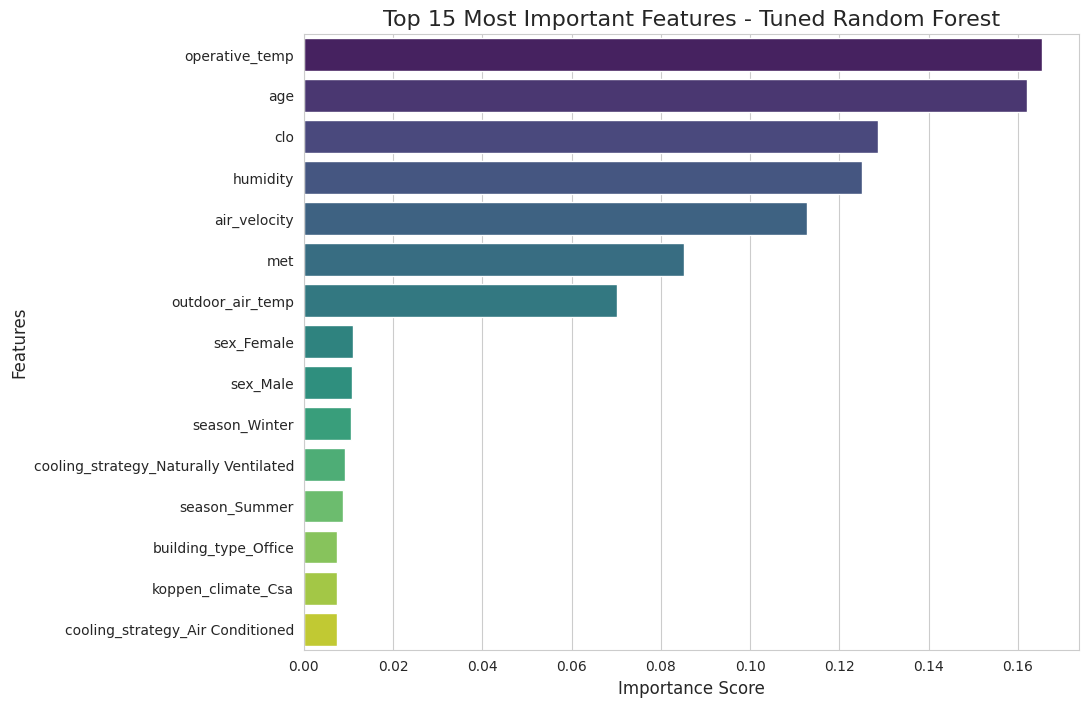

/tmp/ipython-input-41-3623719962.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xgb_importances.values, y=xgb_importances.index, palette='plasma')


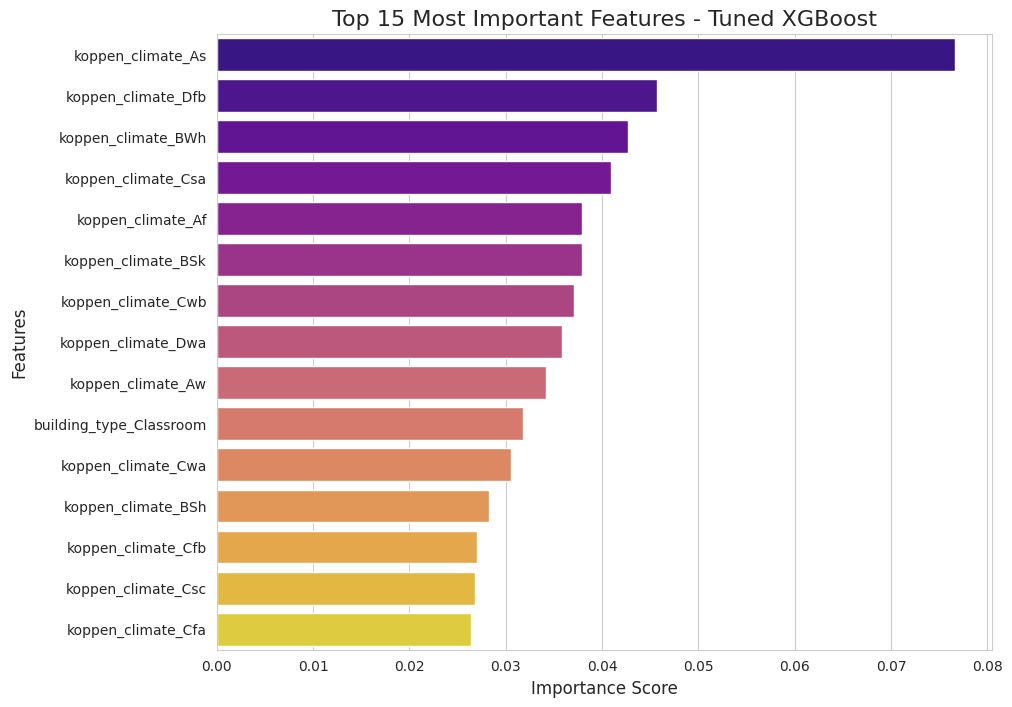

In [ ]:

# Get the feature names from the 'num' transformer
num_features = preprocessor.named_transformers_['num'].get_feature_names_out().tolist()
# Get the feature names from the 'cat' transformer
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out().tolist()

# Combine them into a single list of final feature names
final_feature_names = num_features + cat_features


# --- 1. Feature Importance for Tuned Random Forest ---

# Create a pandas Series for easy plotting
rf_importances = pd.Series(best_rf_model.feature_importances_, index=final_feature_names)
rf_importances = rf_importances.sort_values(ascending=False).head(15) # Get top 15

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x=rf_importances.values, y=rf_importances.index, palette='viridis')
plt.title('Top 15 Most Important Features - Tuned Random Forest', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()


# --- 2. Feature Importance for Tuned XGBoost ---

# Create a pandas Series for easy plotting
xgb_importances = pd.Series(best_xgb_model.feature_importances_, index=final_feature_names)
xgb_importances = xgb_importances.sort_values(ascending=False).head(15) # Get top 15

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x=xgb_importances.values, y=xgb_importances.index, palette='plasma')
plt.title('Top 15 Most Important Features - Tuned XGBoost', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()